In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sdeint

In [2]:
def setaxesfsize(axl,fontsize):
    ticklabelbot = axl.get_xticklabels()
    ticklabelleft = axl.get_yticklabels()
    for labelx in ticklabelbot:
        labelx.set_fontsize(fontsize)
#    i=0
    for labely in ticklabelleft:
#        if i != 0:
            labely.set_fontsize(fontsize)

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


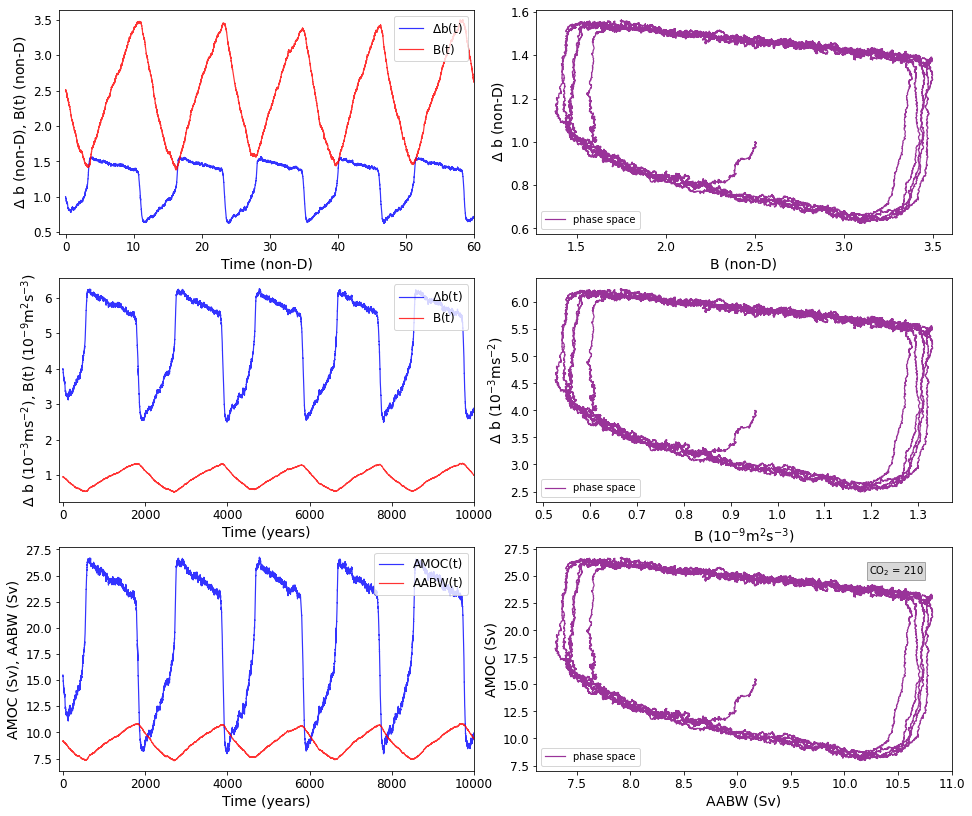

In [3]:
#################################################################
# set up model as defined in Vettoretti et al. 2022             #
#################################################################

# Using Euler-Maruyama

# Notes:
# _nd = non-dimensional units
# _dim = dimensional units

b0 = 0.625
q0 = -9.
q1 = 12.
# non-dimensional timescale
# (a slow/fast system because large numbers in the first eq.)
tau = 0.902
sigma = 0.05

tc= 166.66 # Characteristic time constant
Bbar = 3.4164 
eta = 0.5
gammabar = 1.22
# set the CO2 control level here (will be labeled in the plot)
gamma = 1.2

def B0(gamma):
    return Bbar + eta * (gammabar - gamma)
    
def dA(A, B, gamma):
    drift = -(B - B0(gamma)) - np.abs(q0 + q1*(A - b0))*(A - b0)
    diffusion = sigma * np.random.normal()
    return drift * dt + diffusion * np.sqrt(dt)

def dB(A, gamma):
    drift = (A-gamma)/tau
    diffusion = sigma * np.random.normal()
    return drift * dt + diffusion * np.sqrt(dt)


#################################################################
# run integration                                               #
#################################################################

dt = 0.001
time = np.arange(0,60.01, dt)
AMOC_nd = np.zeros(len(time))
AABW_nd = np.zeros(len(time))
# set the initial condition
AABW_nd[0] = 2.5
AMOC_nd[0] = 1.0

for i,t in enumerate(time[:-1]):
    AMOC_nd[i+1] = AMOC_nd[i] + dA(AMOC_nd[i], AABW_nd[i], gamma)
    AABW_nd[i+1] = AABW_nd[i] + dB(AMOC_nd[i], gamma)


####################################################################
# plots
fig, ax = plt.subplots(3,2, figsize=(16,14))

amoccol = 'blue'
aabwcol = 'red'
phasecol = 'purple'
axfont=12
ax[0,0].plot(time, AMOC_nd, color=amoccol, linewidth = 1.2, alpha=0.8, label = '$\Delta b(t)$') #non-dimensionalize the time
ax[0,0].plot(time, AABW_nd, color=aabwcol, linewidth = 1.2, alpha=0.8, label = '$B(t)$') #non-dimensionalize the time
ax[0,0].legend(loc=1, ncol=1, fontsize=axfont)
ax[0,0].set_xlim(-1,60)
ax[0,0].set_ylabel("$\Delta$ b (non-D), $B(t)$ (non-D)", size=14)
ax[0,0].set_xlabel("Time (non-D)", size=14)

#plot last half of timeseries in phase space
ax[0,1].plot(AABW_nd, AMOC_nd, color=phasecol, linewidth = 1.2, alpha=0.8, label = 'phase space') #remove the transients
ax[0,1].legend(loc=3)

#ax[0,0].set_ylabel("B (non-D)", size=14)
#ax[0,0].set_xlabel("Time (non-D)", size=14)
ax[0,1].set_ylabel("$\Delta$ b (non-D)", size=14)
ax[0,1].set_xlabel("B (non-D)", size=14)


#######################################################################
# now let's dimensionalize in buoyancy and buoyancy flux              #
#######################################################################

#print ('The timescale (tau) is '+str(int(tau*tc))+' years')
secpryr = 3600.0 * 24.0 * 365.0
F0 = 3.0/secpryr # 3 m/yr/(sec/yr) = [m/s]
D = 1000.0 # m (depth of pycnocline)
tc = D/(2*F0*secpryr)
A = 7.0e12 # m^2
qc = A*F0 #characteristic MOC
b_c = 0.004 # charateristic buoyancy gradient
B_c = b_c*F0 # characteristic buoyancy flux
#print (B_c)
# need to scale by e^3 m/s^2 and e^9 m^2/s^3 so we can see the lines on the plots
ax[1,0].plot(time*tc, AMOC_nd * b_c * 1.0e3, color=amoccol, linewidth = 1.2, alpha=0.8, label = '$\Delta b(t)$')
ax[1,0].plot(time*tc, AABW_nd * B_c * 1.0e9, color=aabwcol, linewidth = 1.2, alpha=0.8, label = '$B(t)$')
ax[1,0].legend(loc=1, ncol=1, fontsize=axfont)
ax[1,0].set_xlim(-100,10000)
ax[1,0].set_ylabel("$\Delta$ b ($10^{-3} m s^{-2}$), $B(t)$ ($10^{-9} m^2 s^{-3}$)", size=14)
ax[1,0].set_xlabel("Time (years)", size=14)

#plot last half of timeseries in phase space
ax[1,1].plot(AABW_nd *B_c * 1.0e9, AMOC_nd * b_c * 1.0e3, color=phasecol, linewidth = 1.2, alpha=0.8, label = 'phase space') #remove the transients
ax[1,1].legend(loc=3)

#ax[1,0].set_ylabel("B ($10^{-9} m^2 s^{-3}$)", size=14)
#ax[1,0].set_xlabel("Time (Years)", size=14)
ax[1,1].set_ylabel("$\Delta$ b ($10^{-3} m s^{-2}$)", size=14)
ax[1,1].set_xlabel("B ($10^{-9} m^2 s^{-3}$)", size=14)


#######################################################################
# now plot AMOC and AABW                                              #
#######################################################################
 
psi_0 = -4.5e6 # m^3/s
psi_1 = 20.0e6 # m^3/s
AMOC_dim = psi_0 + psi_1*AMOC_nd
psi_a = 5.0e6 # m^3/s (5 Sv) 
chi = 2.5 # area scale factor

AABW_dim = psi_a + chi * A * (B_c/b_c) *AABW_nd

b_aabw = 2.5*A/b_c # this is A/b_0 area of ocean over mean buoancy gradient)
# need to scale to Sv (1.0e-6 Sv / m^3/s )
ax[2,0].plot(time*tc, AMOC_dim*1.0e-6, color=amoccol, linewidth = 1.2, alpha=0.8, label = 'AMOC(t)')
ax[2,0].plot(time*tc, AABW_dim*1.0e-6, color=aabwcol, linewidth = 1.2, alpha=0.8, label = 'AABW(t)')
ax[2,0].legend(loc=1, ncol=1, fontsize=axfont)
ax[2,0].set_xlim(-100,10000)
ax[2,0].set_xlabel("Time (years)", size=14)
ax[2,0].set_ylabel("AMOC (Sv), AABW (Sv)", size=14)

#plot last half of timeseries in phase space
ax[2,1].plot(AABW_dim*1.0e-6, AMOC_dim*1.0e-6, color=phasecol, linewidth = 1.2, alpha=0.8, label = 'phase space') #remove the transients
ax[2,1].legend(loc=3)

#ax[2,0].set_ylabel("AABW (Sv)", size=14)
#ax[2,0].set_xlabel("Time (Years)", size=14)
ax[2,1].set_ylabel("AMOC (Sv)", size=14)
ax[2,1].set_xlabel("AABW (Sv)", size=14)

# convert buoyancy (gamma to co2) and label plot
a2 = 25
a1 = 12
c2 = 240
c1 = 170
co2  = (1.0e-6*(gamma*b_c * psi_1/b_c + psi_0) - a1) * (c2 - c1) / (a2 - a1) + c1
ax[2,1].text(0.8,0.88,"CO$_2$ = "+str(np.int_(co2)), transform=ax[2,1].transAxes, bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 2})

[[ setaxesfsize(ax[i, j], 12) for i in range(3)] for j in range(2)]

plt.subplots_adjust(hspace = 0.2, wspace=0.15)

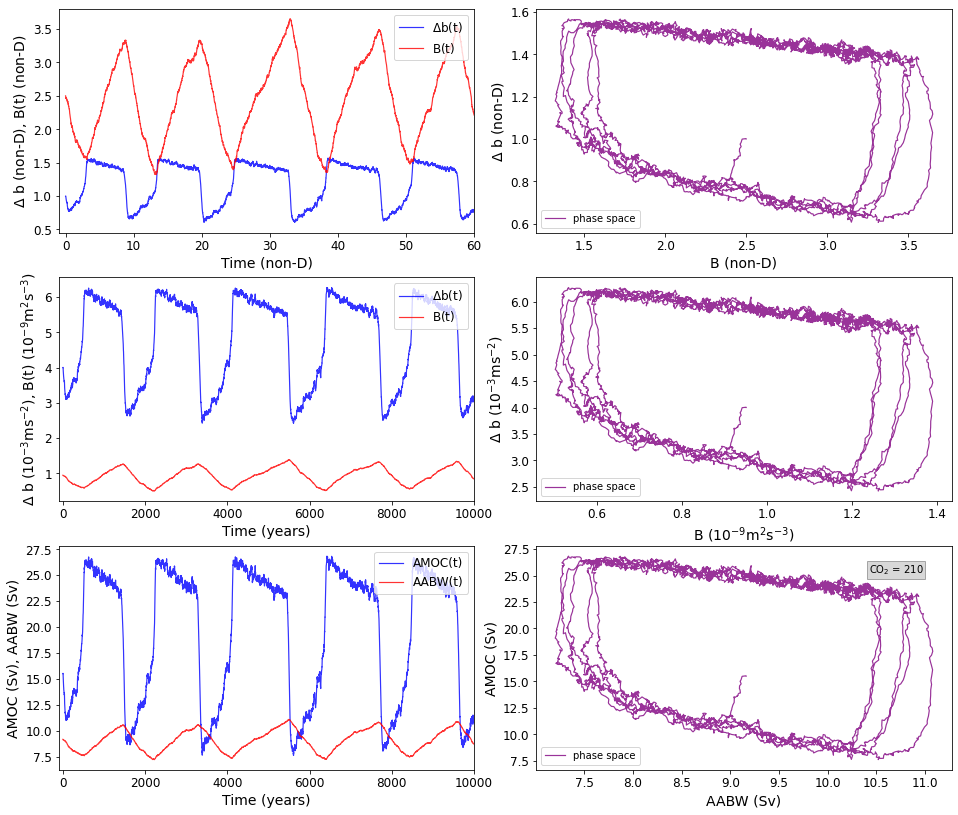

In [4]:
# Or alternatively using SDEint python package

b0, q0, q1, tau, sigma, Bbar, eta, gammabar = 0.625, -9., 12., 0.902, 0.07, 3.4164, 0.5, 1.22

tc= 166.66 # Characteristic time constant
# set the CO2 control level here (will be labeled in the plot)
gamma = 1.2

tspan = np.linspace(0, 60., 6001)
y0 = np.array([1.0, 2.5])

def B0(gamma):
    return Bbar + eta * (gammabar - gamma)
    
def f(y, t):
    b = y[0]
    B = y[1]
    f0 = -(B - B0(gamma)) - abs(q0 + q1*(b - b0))*(b - b0);
    f1 = (b - gamma)/tau;

    return np.array([f0, f1])

def GG(y, t):
    return np.diag([sigma, sigma])

scdom = sdeint.itoint(f, GG, y0, tspan)
AMOC_nd = scdom[:,0]
AABW_nd = scdom[:,1]
time = tspan

####################################################################
# plots
fig, ax = plt.subplots(3,2, figsize=(16,14))

amoccol = 'blue'
aabwcol = 'red'
phasecol = 'purple'
axfont=12
ax[0,0].plot(time, AMOC_nd, color=amoccol, linewidth = 1.2, alpha=0.8, label = '$\Delta b(t)$') #non-dimensionalize the time
ax[0,0].plot(time, AABW_nd, color=aabwcol, linewidth = 1.2, alpha=0.8, label = '$B(t)$') #non-dimensionalize the time
ax[0,0].legend(loc=1, ncol=1, fontsize=axfont)
ax[0,0].set_xlim(-1,60)
ax[0,0].set_ylabel("$\Delta$ b (non-D), $B(t)$ (non-D)", size=14)
ax[0,0].set_xlabel("Time (non-D)", size=14)

#plot last half of timeseries in phase space
ax[0,1].plot(AABW_nd, AMOC_nd, color=phasecol, linewidth = 1.2, alpha=0.8, label = 'phase space') #remove the transients
ax[0,1].legend(loc=3)

#ax[0,0].set_ylabel("B (non-D)", size=14)
#ax[0,0].set_xlabel("Time (non-D)", size=14)
ax[0,1].set_ylabel("$\Delta$ b (non-D)", size=14)
ax[0,1].set_xlabel("B (non-D)", size=14)


#######################################################################
# now let's dimensionalize in buoyancy and buoyancy flux              #
#######################################################################

#print ('The timescale (tau) is '+str(int(tau*tc))+' years')
secpryr = 3600.0 * 24.0 * 365.0
F0 = 3.0/secpryr # 3 m/yr/(sec/yr) = [m/s]
D = 1000.0 # m (depth of pycnocline)
tc = D/(2*F0*secpryr)
A = 7.0e12 # m^2
qc = A*F0 #characteristic MOC
b_c = 0.004 # charateristic buoyancy gradient
B_c = b_c*F0 # characteristic buoyancy flux
#print (B_c)
# need to scale by e^3 m/s^2 and e^9 m^2/s^3 so we can see the lines on the plots
ax[1,0].plot(time*tc, AMOC_nd * b_c * 1.0e3, color=amoccol, linewidth = 1.2, alpha=0.8, label = '$\Delta b(t)$')
ax[1,0].plot(time*tc, AABW_nd * B_c * 1.0e9, color=aabwcol, linewidth = 1.2, alpha=0.8, label = '$B(t)$')
ax[1,0].legend(loc=1, ncol=1, fontsize=axfont)
ax[1,0].set_xlim(-100,10000)
ax[1,0].set_ylabel("$\Delta$ b ($10^{-3} m s^{-2}$), $B(t)$ ($10^{-9} m^2 s^{-3}$)", size=14)
ax[1,0].set_xlabel("Time (years)", size=14)

#plot last half of timeseries in phase space
ax[1,1].plot(AABW_nd *B_c * 1.0e9, AMOC_nd * b_c * 1.0e3, color=phasecol, linewidth = 1.2, alpha=0.8, label = 'phase space') #remove the transients
ax[1,1].legend(loc=3)

#ax[1,0].set_ylabel("B ($10^{-9} m^2 s^{-3}$)", size=14)
#ax[1,0].set_xlabel("Time (Years)", size=14)
ax[1,1].set_ylabel("$\Delta$ b ($10^{-3} m s^{-2}$)", size=14)
ax[1,1].set_xlabel("B ($10^{-9} m^2 s^{-3}$)", size=14)


#######################################################################
# now plot AMOC and AABW                                              #
#######################################################################
 
psi_0 = -4.5e6 # m^3/s
psi_1 = 20.0e6 # m^3/s
AMOC_dim = psi_0 + psi_1*AMOC_nd
psi_a = 5.0e6 # m^3/s (5 Sv) 
chi = 2.5 # area scale factor

AABW_dim = psi_a + chi * A * (B_c/b_c) *AABW_nd

b_aabw = 2.5*A/b_c # this is A/b_0 area of ocean over mean buoancy gradient)
# need to scale to Sv (1.0e-6 Sv / m^3/s )
ax[2,0].plot(time*tc, AMOC_dim*1.0e-6, color=amoccol, linewidth = 1.2, alpha=0.8, label = 'AMOC(t)')
ax[2,0].plot(time*tc, AABW_dim*1.0e-6, color=aabwcol, linewidth = 1.2, alpha=0.8, label = 'AABW(t)')
ax[2,0].legend(loc=1, ncol=1, fontsize=axfont)
ax[2,0].set_xlim(-100,10000)
ax[2,0].set_xlabel("Time (years)", size=14)
ax[2,0].set_ylabel("AMOC (Sv), AABW (Sv)", size=14)

#plot last half of timeseries in phase space
ax[2,1].plot(AABW_dim*1.0e-6, AMOC_dim*1.0e-6, color=phasecol, linewidth = 1.2, alpha=0.8, label = 'phase space') #remove the transients
ax[2,1].legend(loc=3)

#ax[2,0].set_ylabel("AABW (Sv)", size=14)
#ax[2,0].set_xlabel("Time (Years)", size=14)
ax[2,1].set_ylabel("AMOC (Sv)", size=14)
ax[2,1].set_xlabel("AABW (Sv)", size=14)

# convert buoyancy (gamma to co2) and label plot
a2 = 25
a1 = 12
c2 = 240
c1 = 170
co2  = (1.0e-6*(gamma*b_c * psi_1/b_c + psi_0) - a1) * (c2 - c1) / (a2 - a1) + c1
ax[2,1].text(0.8,0.88,"CO$_2$ = "+str(np.int_(co2)), transform=ax[2,1].transAxes, bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 2})

[[ setaxesfsize(ax[i, j], 12) for i in range(3)] for j in range(2)]

plt.subplots_adjust(hspace = 0.2, wspace=0.15)